# Airbnb Data Analysis for New York City

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
import cufflinks as cf
import datetime
import calendar as cal
import seaborn as sns

from plotly.subplots import make_subplots
from matplotlib.cbook import boxplot_stats
from IPython.display import display, display_html

pio.templates.default = 'none'

%matplotlib inline
!python --version

Python 3.8.5


## 1. Business Understanding

Some questions that I would like to gain insight into from this analysis are the following:
-  **Which NYC areas have the most listings?**
-  **What does availability for listings look like throughout the year?**
-  **How do listing prices vary by location?**
-  **How do listing prices change throughout the year?**

Notice that these four questions are exploratory in nature, thus we will be examining descriptive statistics and visual trends around these questions.

---

## 2. Data Understanding

A full library of Airbnb data for cities globally can be found [here](http://insideairbnb.com/get-the-data.html).  Under the New York City section, the datasets that are available for download are:
* calendar - Detailed Calendar Data for listings in New York City
* listings - Detailed Listings data for New York City
* reviews - Detailed Review Data for listings in New York City
* neighbourhoods - Neighbourhood list for geo filter

Since my questions that I would like to answer revolve around availability and pricing, I will primarily be using the first data set above in this exploratory analysis, as well as the `listings` dataset just to pull in some supplementary data (i.e. neighbourhood features).  Also, to get a better idea of the temporal trends around availability and pricing, I will be looking at the `calendar` data from June 2018 to June 2020 where possible.

Now let's take a closer look at some of the characteristics of this data, including the data's cleanliness and completeness.

#### Calendar Dataset.

In [2]:
# Load in the Calendar csv files
calendar_june2018 = pd.read_csv('data/calendar_june2018.csv')
calendar_june2019 = pd.read_csv('data/calendar_june2019.csv')

Let's take a look at these dataframes to get an idea of what the data looks like.

In [3]:
display(calendar_june2018.head())
display(calendar_june2019.head())

,listing_id,date,available,price
0,182177,2019-06-04,f,NaN
1,182177,2019-06-03,t,$136.00
2,182177,2019-06-02,t,$136.00
3,182177,2019-06-01,t,$136.00
4,182177,2019-05-31,t,$136.00


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,18764,2019-06-03,f,$145.00,$145.00,3.0,90.0
1,18764,2019-06-04,f,$145.00,$145.00,3.0,90.0
2,18764,2019-06-05,t,$145.00,$145.00,3.0,90.0
3,18764,2019-06-06,f,$145.00,$145.00,3.0,90.0
4,18764,2019-06-07,f,$145.00,$145.00,3.0,90.0


In [4]:
print('**Summary of June 2018 dataframe features:**')
print(calendar_june2018.info())
#print(calendar_june2018.describe(include='all'))
print('\n**Summary of June 2019 dataframe features:**')
print(calendar_june2019.info())
#print(calendar_june2019.describe(include='all'))

**Summary of June 2018 dataframe features:**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17351735 entries, 0 to 17351734
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   listing_id  int64 
 1   date        object
 2   available   object
 3   price       object
dtypes: int64(1), object(3)
memory usage: 529.5+ MB
None

**Summary of June 2019 dataframe features:**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812547 entries, 0 to 17812546
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 951.3+ MB
None


There are three additional features in the 2019 data set that do not exist in the 2018 data set, but are not really relevant to our analysis here (and so will be dropped in the Data Preparation section).  Thus, we are left with the following features. 

**Features of interest:**

* **listing_id** - unique identifier for the listing
* **date** - specific date on the calendar (e.g. 2019-06-03)
* **available** - whether the listing is available or not on the given date (t or f)
* **price** - original price of listing in \$

Let's take a closer look at our features of interest, starting with the number of unique listings and date ranges for both calendar dataframes.

In [5]:
print('There are {} unique listings from {} to {}.'
      .format(calendar_june2018.listing_id.nunique(),
              calendar_june2018.date.min(), calendar_june2018.date.max()))
print('There are {} unique listings from {} to {}.'
      .format(calendar_june2019.listing_id.nunique(),
              calendar_june2019.date.min(), calendar_june2019.date.max()))

There are 47539 unique listings from 2018-06-03 to 2019-06-04.
There are 48801 unique listings from 2019-06-02 to 2020-06-01.


Each calendar dataset covers approximately one year worth of data for the following year.  We will want to convert the **date** feature to a datetime data type in the Data Preparation section below.

In [6]:
# Unique values for available feature
print('Distinct values of "available" feature in 2018 dataset: ', calendar_june2018.available.unique())
print('Distinct values of "available" feature in 2019 dataset: ', calendar_june2019.available.unique())

Distinct values of "available" feature in 2018 dataset:  ['f' 't']
Distinct values of "available" feature in 2019 dataset:  ['f' 't']


The **available** feature in both datasets is of boolean-type, where "f" means that the listing is not available for that given day, while "t" means that the listing is available for that given day. We should convert these to 0 and 1, respectively in the Data Preparation section below.

In [7]:
# Features with missing values
print('Feature(s) with missing values in 2018 dataset: ', calendar_june2018.columns[calendar_june2018.isnull().any()].tolist())
print('Feature(s) with missing values in 2019 dataset: ', calendar_june2019.columns[calendar_june2019.isnull().any()].tolist())

Feature(s) with missing values in 2018 dataset:  ['price']
Feature(s) with missing values in 2019 dataset:  ['minimum_nights', 'maximum_nights']


The only feature with missing values in the 2018 dataset is **price**, while the two features with missing values in the 2019 dataset are ones that are not relevant in this analysis i.e. we can ignore them here. Let's take a look at the proportion of missing data for **price** and check if it is perhaps related to the availability of the listing or truly missing data. 

In [8]:
# Percent of missing prices per listing
grp_null_price = calendar_june2018.groupby('listing_id').apply(lambda x: x.price.isnull().sum()/len(x)).reset_index()
grp_null_price.columns = ['listing_id', 'perc_null_price']
# Listings where price is ALWAYS null
no_price = grp_null_price[grp_null_price['perc_null_price'] == 1.0]

# Data completeness and cleanliness checks:
print('Data Completeness\Cleanliness Checks:')
print('******************************************')
print('2018 Data:')
print('- Percentage of rows in the dataset with a missing price: {:.3f}% (n = {} rows)'
      .format(calendar_june2018['price'].isna().mean() * 100, calendar_june2018['price'].isna().sum()))
print('- Percentage of rows where an available listing has a missing price (indicating incomplete data): {}%'
      .format(((calendar_june2018['price'].isna()) & (calendar_june2018['available'] == 't')).mean()*100))
print('- Percentage of unique listings where no price is found in the dataset: {:.3f}% (n = {} listings)'
      .format(no_price.shape[0]/calendar_june2018.listing_id.nunique()*100, no_price['listing_id'].nunique()))
print('\n- Number of rows with a listing price of $0: {}'
      .format(len(calendar_june2018[calendar_june2018['price'] == '$0.00'])))
print('- Number of rows where an available listing has a price of $0 (indicating unclean data): {}'
      .format(len(calendar_june2018[(calendar_june2018['price'] == '$0.00') & (calendar_june2018['available'] == 't')])))

print('******************************************')
print('2019 Data:')
print('- Number of rows with a listing price of $0: {} (n = {} listings)'
      .format(len(calendar_june2019[calendar_june2019['price'] == '$0.00']), 
              calendar_june2019[(calendar_june2019['price'] == '$0.00') & (calendar_june2019['available'] == 't')]['listing_id'].nunique()))
print('- Number of rows where an available listing has a price of $0 (indicating unclean data): {}'
      .format(len(calendar_june2019[(calendar_june2019['price'] == '$0.00') & (calendar_june2019['available'] == 't')])))

Data Completeness\Cleanliness Checks:
******************************************
2018 Data:
- Percentage of rows in the dataset with a missing price: 71.234% (n = 12360337 rows)
- Percentage of rows where an available listing has a missing price (indicating incomplete data): 0.0%
- Percentage of unique listings where no price is found in the dataset: 37.893% (n = 18014 listings)

- Number of rows with a listing price of $0: 362
- Number of rows where an available listing has a price of $0 (indicating unclean data): 362
******************************************
2019 Data:
- Number of rows with a listing price of $0: 730 (n = 2 listings)
- Number of rows where an available listing has a price of $0 (indicating unclean data): 726


In [9]:
# Which two listings in 2019 dataset have price = $0
print('Listings with a price of "$0" in 2019 dataset: ', calendar_june2019[(calendar_june2019['price'] == '$0.00') & (calendar_june2019['available'] == 't')]['listing_id'].unique().tolist())

Listings with a price of "$0" in 2019 dataset:  [20933849, 28107839]


A little over 70% of the 2018 data contains a missing price which is *quite* substantial, but after taking a closer look, all listings marked as unavailable also have a missing price.  It's possible that the price was intentionally left out for unavailable listings (and I see this same pattern in older data sets of prior months/years for NYC), but this is *not* the case for the 2019 data set where the price still exists for unavailable listings.  Due to this discrepancy and to keep things simple, we will only be using the 2019 dataset when exploring pricing trends for a full calendar year.

This feature will also need some cleanup/attention: the "\$" character in the values should be converted to a numeric, and the rows with a listing price of &dollar;0 should be dropped when looking at pricing trends for the 2019 dataset.

#### Listings Dataset.

In [10]:
# Load in the 2019 listings csv file
# listings_june2019 = pd.read_csv('~/Desktop/Udacity/Term2/Introduction to Data Science/Project - Write a Data Science Blog Post/data/listings_june2019.csv', low_memory = False)
listings_june2019 = pd.read_csv('data/listings_june2019.csv', low_memory = False)

print('There are {} features and {} unique listings in the 2019 listings dataset.'
      .format(len(listings_june2019.columns), listings_june2019['id'].nunique()))

There are 106 features and 48801 unique listings in the 2019 listings dataset.


Of these 106 features in this dataset, we only care about three.

**Features of interest:**

* **id** - unique identifier for the listing
* **neighbourhood_cleansed** - the neighbourhood location of the listing
* **neighbourhood_group_cleansed** - the neighbourhood group (i.e. borough) location of the listing

We will want to map these two neighbourhood features to the `calendar` dataset using the listing ID feature (called "id" here)

In [11]:
listings_june2019[['id', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].head()

,id,neighbourhood_cleansed,neighbourhood_group_cleansed
0,2539,Kensington,Brooklyn
1,2595,Midtown,Manhattan
2,3647,Harlem,Manhattan
3,3831,Clinton Hill,Brooklyn
4,4989,Hell's Kitchen,Manhattan


Now that we have an idea of what the dataset looks like, the next step in the CRISP-DM process is to prep the data for analysis. We may want to brew a fresh pot of coffee for this :)

---

## 3. Data Preparation

**Time for some wrangling!**

From a high-level, we will do two things in this section:
1. Combine the 2018 and 2019 data for `calender` and `listings` datasets to use later for some time-series analysis.
2. Clean up `calender` dataset - data type conversions, handle missing values and categorical features properly, etc.

### 3.1 Combining the datasets

* Things to do:
    1. Remove irrelevant columns from 2019 data sets that do not exist in 2018 data sets.
    2. Concatenate the csv's to get a complete data set from June 2018-2020 for both calendar and listings datasets.

**Calendar dataset**

In [12]:
# Load in the Calendar csv files
calendar_june2018 = pd.read_csv('data/calendar_june2018.csv')
calendar_june2019 = pd.read_csv('data/calendar_june2019.csv')

# Remove the three additional columns from calendar_june2019 that do not exist in calendar_june2018
calendar_june2019 = calendar_june2019.drop(['adjusted_price', 'minimum_nights', 'maximum_nights'], axis = 1)

# Remove duplicate records on overlapping dates (2019-06-02, 2019-06-03, 2019-06-04), keeping the last occurrence (which contains price instead of NaN)
# Concatenate the csv's to get complete calendar dataset from June 2018-2020
calendar = pd.concat([calendar_june2018, calendar_june2019], ignore_index = True).drop_duplicates(subset = ['date', 'listing_id', 'available'], keep = 'last').reset_index(drop = True)

print('There are a total of {} days and {} unique listings in the combined Calendar dataset ({} to {}).'
      .format(calendar.date.nunique(), calendar.listing_id.nunique(), 
              calendar.date.min(), calendar.date.max()))

There are a total of 730 days and 67403 unique listings in the combined Calendar dataset (2018-06-03 to 2020-06-01).


**Listings dataset**

In [13]:
# Load in the Listings csv files
listings_june2018 = pd.read_csv('data/listings_june2018.csv', low_memory = False)
listings_june2019 = pd.read_csv('data/listings_june2019.csv', low_memory = False)

# Remove the ten additional columns from listings_june2019 that do not exist in listings_june2018
diff_cols = listings_june2019.columns.difference(listings_june2018.columns)
listings_june2019 = listings_june2019.drop(listings_june2019[diff_cols], axis = 1)

# Remove duplicate records on overlapping dates (2019-06-02, 2019-06-03, 2019-06-04)
# Concatenate the csv's to get complete listing dataset from June 2018-2020
listings = pd.concat([listings_june2018, listings_june2019], ignore_index = True).drop_duplicates(keep = 'last').reset_index(drop = True)

# Rename id (from listings) to listing_id for consistency.
listings = listings.rename(columns = {"id": "listing_id"})
listings_june2018 = listings_june2018.rename(columns = {"id": "listing_id"})
listings_june2019 = listings_june2019.rename(columns = {"id": "listing_id"})

print('There are a total of {} unique listings in the combined Listings dataset.'.format(listings.listing_id.nunique()))

There are a total of 67404 unique listings in the combined Listings dataset.


### 3.2 Data Cleansing

**Calendar dataset** 

* **Things to do:**
   - Remove any rows that a **price** of \$0 (dirty data).
   - Convert the **available** feature to 0 if not available and 1 if available.
   - Remove the '$' character in the **price** feature and convert it to a numeric.
   - Convert the **date** feature to a datetime data type and add corresponding **day_of_week**, **month**, and **year** features to each record.
   - Pull the **neighbourhood_group_cleansed** feature from the `listings` dataset and add as new feature for each listing.

In [14]:
calendar.head()

,listing_id,date,available,price
0,182177,2019-06-04,f,NaN
1,182177,2019-06-02,t,$136.00
2,182177,2019-06-01,t,$136.00
3,182177,2019-05-31,t,$136.00
4,182177,2019-05-30,t,$136.00


In [15]:
# Function that cleans a calendar dataset
def clean_cal(df):
    """
    Input: The (calendar) dataframe to be cleaned.
    This function does the following:
        - removes any rows that have a price of $0
        - converts the available feature to 0 if not available and 1 if available
        - removes the '$' character in the price feature and converts it to a numeric
        - TEMP: replace the missing values in price with the mean price per listing
        - converts the date feature to a datetime data type
        - adds the corresponding day_of_week, month, and year features from date to each record     
    Output: A clean (calendar) dataframe.
    
    """

    # Remove any rows that have a price of $0 (removes two listings total).
    df.drop(df[df['price'] == '$0.00'].index, inplace = True)

    # Convert the available feature to 0 if not available and 1 if available.
    df.loc[:,'available'] = df['available'].map({'t':1, 'f':0})

    # Remove the '$' character in the price feature and convert it to a numeric.
    df.loc[:,'price'] = df['price'].replace('[\$,]', '', regex = True).astype(float)
    
    # Convert the date feature to a datetime data type.
    df.loc[:,'date'] = pd.to_datetime(df['date'])

    # Add corresponding day_of_week feature to each record.
    df.loc[:,'day_of_week'] = df['date'].dt.day_name()
    # Add corresponding month feature to each record.
    df.loc[:,'month'] = df['date'].dt.strftime('%B')
    # Add corresponding year feature to each record.
    df.loc[:,'year'] = df['date'].dt.year.astype(str)

    return df


# Function that maps neighbourhood features from one dataframe to another
def map_neighbourhood(df_cal, df_list):
    """
    Input: df_cal is the dataframe that needs the neighbourhood features.
           df_list is the dataframe that already has the neighbourhood features.
    This function creates a mapping between listing_id and neighbourhood/neighbourhood groups from the listings df 
    and then maps those new features to the calendar df.
    Output: The first dataframe (df_cal) containing the mapped neighbourhood features.
    
    """
    
    # Create mapping between listing_id and neighbourhood from listings df
    neighb_mapping = dict(df_list[['listing_id', 'neighbourhood_cleansed']].values)
    # Map to cal df
    df_cal.loc[:,'neighbourhood'] = df_cal['listing_id'].map(neighb_mapping)

    # Create mapping between listing_id and neighbourhood group from listings df
    neighb_group_mapping = dict(df_list[['listing_id', 'neighbourhood_group_cleansed']].values)
    # Map to cal df
    df_cal.loc[:,'neighbourhood_group'] = df_cal['listing_id'].map(neighb_group_mapping)

    return df_cal

In [16]:
# Call clean_cal() function to clean up the individual and combined calendar datasets
cal_clean2018 = clean_cal(calendar_june2018)
cal_clean2019 = clean_cal(calendar_june2019)
calendar_clean = clean_cal(calendar)

# Call map_neighbourhood() function to map the neighbourhood features from the listings datasets to the calender datasets.
cal_final2018 = map_neighbourhood(cal_clean2018, listings_june2018)
cal_final2019 = map_neighbourhood(cal_clean2019, listings_june2019)
calendar_final = map_neighbourhood(calendar_clean, listings)

In [17]:
# Double check data looks ok
calendar_final.head()

,listing_id,date,available,price,day_of_week,month,year,neighbourhood,neighbourhood_group
0,182177,2019-06-04,0,NaN,Tuesday,June,2019,Allerton,Bronx
1,182177,2019-06-02,1,136.0,Sunday,June,2019,Allerton,Bronx
2,182177,2019-06-01,1,136.0,Saturday,June,2019,Allerton,Bronx
3,182177,2019-05-31,1,136.0,Friday,May,2019,Allerton,Bronx
4,182177,2019-05-30,1,136.0,Thursday,May,2019,Allerton,Bronx


So after cleaning, we are left with:
* numerical features: **listing_id**, **available**, **price**
* categorical features: **day_of_week**, **month**, **year**, **neighbourhood**, and **neighbourhood_group**
* datetime feature: **date**

---

## Exploratory Analysis

Now that our data is prepped and ready to go, let's address our exploratory analysis questions:
-  **Which NYC areas have the most listings?**
-  **What does availability for listings look like throughout the year?**
-  **How do listing prices vary by location?**
-  **How do listing prices change throughout the year?**

### Availability analysis.

**- QUESTION: Which NYC areas have the most listings?**

Let's take a look at the number of unique listings for each borough (i.e. 'neighbourhood_group') and neighbourhood (which is more granular).

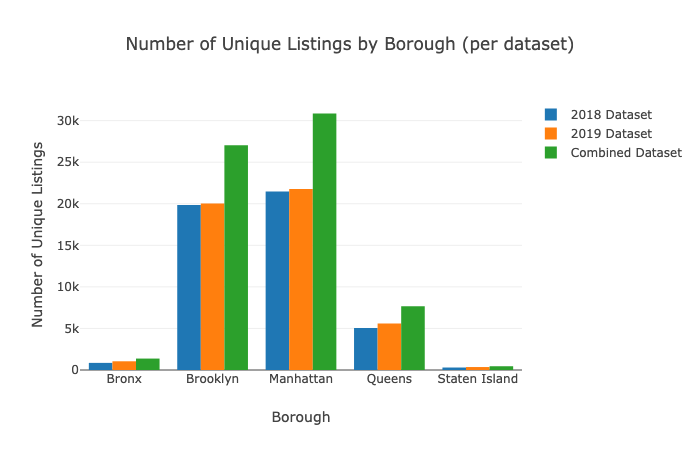

In [18]:
# Number of unique listings by borough for each dataset
cal_bor_all = calendar_final[['listing_id', 'neighbourhood_group', 'date']].copy()
nunique_all = cal_bor_all.groupby('neighbourhood_group')['listing_id'].nunique().reset_index()
nunique_all.columns = ['neighbourhood_group', 'nunique']
cal_bor2018 = cal_final2018[['listing_id', 'neighbourhood_group', 'date']].copy()
nunique_2018 = cal_bor2018.groupby('neighbourhood_group')['listing_id'].nunique().reset_index()
nunique_2018.columns = ['neighbourhood_group', 'nunique']
cal_bor2019 = cal_final2019[['listing_id', 'neighbourhood_group', 'date']].copy()
nunique_2019 = cal_bor2019.groupby('neighbourhood_group')['listing_id'].nunique().reset_index()
nunique_2019.columns = ['neighbourhood_group', 'nunique']

# Plot - num of unique listings by borough for individual data sets
trace1 = go.Bar(
    x = nunique_2018['neighbourhood_group'],
    y = nunique_2018['nunique'],
    name = '2018 Dataset'
)
trace2 = go.Bar(
    x = nunique_2019['neighbourhood_group'],
    y = nunique_2019['nunique'],
    name='2019 Dataset'
)
trace3 = go.Bar(
    x = nunique_all['neighbourhood_group'],
    y = nunique_all['nunique'],
    name='Combined Dataset'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Number of Unique Listings by Borough (per dataset)',
    yaxis_title = 'Number of Unique Listings',
    xaxis_title = 'Borough',
    barmode = 'group'
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe_connected+png")

In [19]:
nunique_2019['percent'] = nunique_2019['nunique']/cal_final2019['listing_id'].nunique()*100
print('- Percentage of listings that are in Manhattan and Brooklyn in 2019 dataset: {:.3f}%'
      .format(nunique_2019.loc[(nunique_2019['neighbourhood_group'] == 'Manhattan') | (nunique_2019['neighbourhood_group'] == 'Brooklyn'), 'percent'].sum()))

- Percentage of listings that are in Manhattan and Brooklyn in 2019 dataset: 85.672%


It's clear that Manhattan and Brooklyn by far have the most number of listings when comparing the boroughs, comprising of 85% of all listings in the 2019 calendar dataset. Manhattan alone has a total of over 30k unique listings between the 2018 and 2019 datasets, which is not surprising since it is the most popular borough from a tourism perspective.

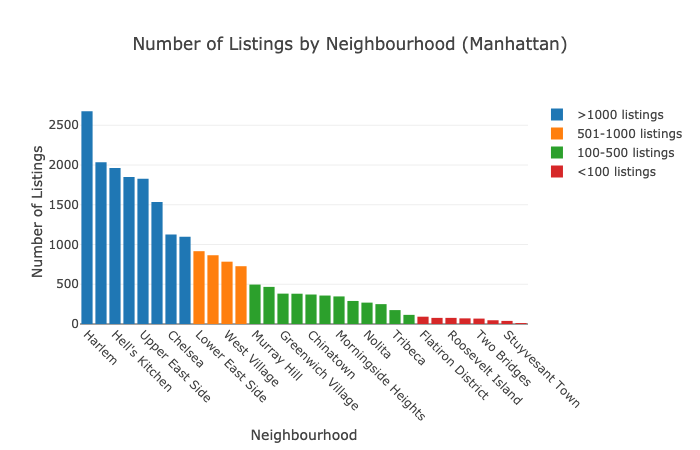

In [20]:
# Number of unique listings by neighbourhood in Manhattan
cal_neigh = cal_final2019[['listing_id', 'neighbourhood', 'neighbourhood_group', 'date']].copy()
nunique_manhatt = cal_final2019[cal_final2019['neighbourhood_group'] == 'Manhattan'].groupby('neighbourhood')['listing_id'].nunique().sort_values(ascending=False).reset_index()
nunique_manhatt.columns = ['neighbourhood', 'nunique']
# Create bins for nunique ranges
nunique_manhatt['label'] = pd.cut(nunique_manhatt['nunique'], [0, 99, 500, 1000, 3000],
                                  labels=['<100 listings', '100-500 listings', '501-1000 listings', '>1000 listings'])

# Plot
data = [dict(
    type = 'bar',
    x = nunique_manhatt['neighbourhood'],
    y = nunique_manhatt['nunique'],
    transforms = [dict(
        type = 'groupby',
        groups = nunique_manhatt['label'])]
)]

layout = dict(
    yaxis = dict(title = 'Number of Listings'),
    xaxis = dict(title = 'Neighbourhood', automargin = True, tickangle = 45),
    title = 'Number of Listings by Neighbourhood (Manhattan)'
)

fig = dict(data=data, layout=layout)
pio.show(fig, validate=False, renderer="iframe_connected+png")

# another way to color bars by label
# data = []
# for label, label_df in nunique_manhatt.groupby('label'):
#     data.append(go.Bar(x=label_df['neighbourhood'],
#                        y=label_df['nunique'],
#                        name=label))
    
# layout = go.Layout(
#     title = 'Number of Listings by Neighbourhood (Manhattan)',
#     yaxis_title = 'Number of Listings',
#     xaxis_title = 'Neighbourhood',
#     xaxis = dict(categoryorder = 'total descending', automargin = True, tickangle = 45), legend_traceorder = 'reversed'
# )

# fig = go.Figure(data=data, layout=layout)
# fig.show(renderer="iframe_connected")

It looks like Harlem (in Uptown Manhattan) has the most number of listings compared to other neighbourhoods, consisting of over 600 more listings than the next neighbourhood with the second highest count, Upper West Side (also Uptown). 

When considering what general areas of Manhattan - Uptown, Midtown, and Downtown - these neighbourhoods are in, the neighbourhoods that have:
* \> 1000 listings (blue bars in plot) are predominantly in Uptown and Midtown 
* 500-1000 listings (orange bars in plot) are predominantly Downtown
* 100-500 listings (green bars in plot) are predominantly Midtown and Downtown
* < 100 listings (red bars in plot) are predominantly Downtown

Now that we have an idea on number of listings per area, let's look at some availability trends.

**- QUESTION: What does availability for listings look like throughout the year?**

In [21]:
availability = calendar_final[['date', 'month', 'year', 'day_of_week', 'available', 'neighbourhood', 'neighbourhood_group']].copy()
availability['booked'] = availability['available'].map(lambda x: 0 if x == 1 else 1)
availability.head()

,date,month,year,day_of_week,available,neighbourhood,neighbourhood_group,booked
0,2019-06-04,June,2019,Tuesday,0,Allerton,Bronx,1
1,2019-06-02,June,2019,Sunday,1,Allerton,Bronx,0
2,2019-06-01,June,2019,Saturday,1,Allerton,Bronx,0
3,2019-05-31,May,2019,Friday,1,Allerton,Bronx,0
4,2019-05-30,May,2019,Thursday,1,Allerton,Bronx,0


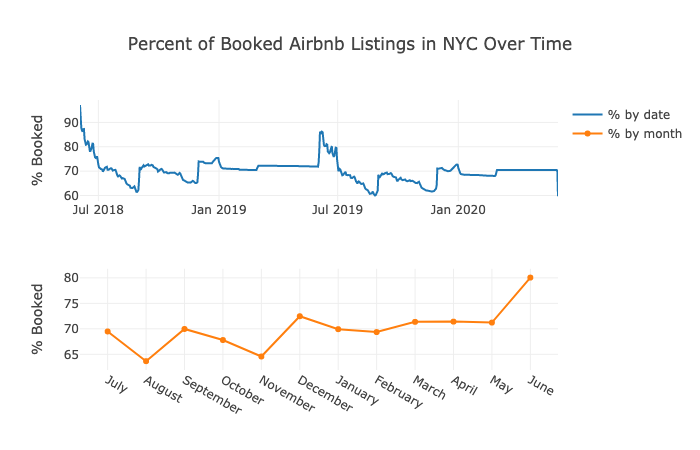

In [22]:
# Group mean of listings booked by date
mean_date_booked = availability.groupby('date')['booked'].mean().reset_index()
# Group mean of listings booked by month
mean_month_booked = availability.groupby(availability['month'], sort=False)['booked'].mean().reset_index()

# Plot
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.25)

fig.add_trace(go.Scatter(x=mean_date_booked['date'].tolist(), y=(mean_date_booked['booked']*100).tolist(), name="% by date"), row=1, col=1)
fig.add_trace(go.Scatter(x=mean_month_booked['month'].tolist(), y=(mean_month_booked['booked']*100).tolist(), name="% by month"), row=2, col=1)

#fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(row=2, col=1, autorange='reversed')
fig.update_yaxes(title_text="% Booked", row=1, col=1)
fig.update_yaxes(title_text="% Booked", row=2, col=1)
fig.update_layout(height=600, title_text="Percent of Booked Airbnb Listings in NYC Over Time")

fig.show(renderer="iframe_connected+png")

When grouping by date, we can see a similar pattern (i.e. seasonality) of average listings booked across the two year time range (June 2018 to June 2020), where the most booked listings are throughout the month of June followed by late December going into the new year. 
* This makes sense for late December since many people venture in to celebrate Christmas time (and see the famous Rockefeller Center Christmas Tree), as well as to bring in the new year in style for New Years Eve (December 31st).
* As for June, this may also be somewhat true empirically since I notice that more tourists start coming out to see the sites during this time, but I'm not totally convinced - this high percentage of bookings may potentially be due to the fact it is the starting month of the June data that was collected/extracted from InsideAirbnb.  It would make sense that the first month of the data pulled has the highest number of bookings since it is the most recent (as in most up-to-date) month of the entire dataset, thus the listings for this month would contain the most number of bookings as compared to say 5 months from the starting month.  
    * One way to validate this - which we will below - is to select a completely different month for NYC from Inside Airbnb (perhaps in a different season as well) to see if the highest number of bookings show the beginning of that month as well.

On the other hand, we can see the least booked listings occur during late August and late November. This may be reflective of NYC's most hot and humid month (August) and Thanksgiving (end of November) where people tend to spend time at home with family rather than travel for vacation.

Let's test our theory about the first of the dataset month by pulling the Inside Airbnb data for the month of October in 2018. 

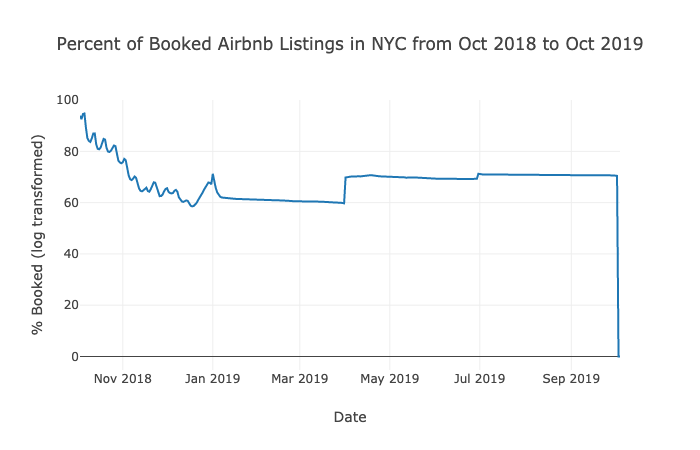

In [23]:
# Load Oct 2018 cal dataset to test above theory
# Load in the Calendar csv files
calendar_oct2018 = pd.read_csv('data/calendar_oct2018.csv')

# Clean dataset
oct_clean2018 = clean_cal(calendar_oct2018)
oct_availability = oct_clean2018[['date', 'month', 'year', 'day_of_week', 'available']].copy()
oct_availability['booked'] = oct_availability['available'].map(lambda x: 0 if x == 1 else 1)

# Group mean of listings booked by date
oct_mean_date_booked = oct_availability.groupby('date')['booked'].mean().reset_index()

data = [go.Scatter(
    x = oct_mean_date_booked['date'], 
    y = oct_mean_date_booked['booked']*100)]

layout = go.Layout(
    yaxis = dict(title = '% Booked (log transformed)'),
    xaxis = dict(title = 'Date'),
    title = 'Percent of Booked Airbnb Listings in NYC from Oct 2018 to Oct 2019')

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe_connected+png")

This plot confirms my above theory that the first month of the dataset will most likely always have the highest number of listings booked and should be caveated when reporting on the results.

Next, let's look at availability more granularly by breaking it down by borough.

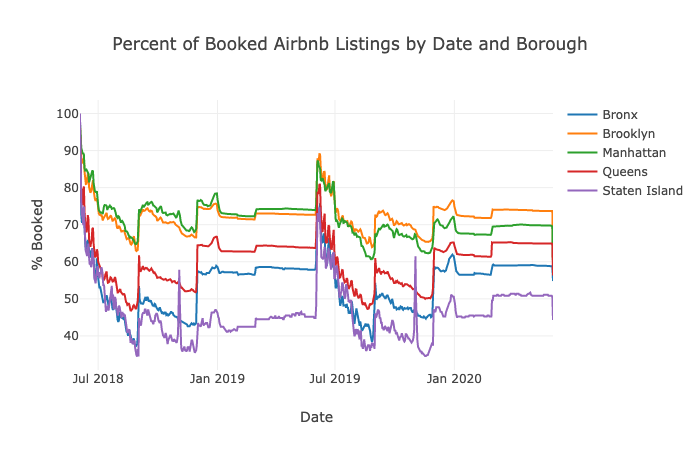

In [24]:
# Plot daily mean booked by borough
mean_date_booked_bor = availability.groupby(['date', 'neighbourhood_group'])['booked'].mean().reset_index()

data = [dict(
  type = 'scatter',
  x = mean_date_booked_bor['date'],
  y = mean_date_booked_bor['booked']*100,
  mode = 'lines',
  transforms = [dict(
    type = 'groupby',
    groups = mean_date_booked_bor['neighbourhood_group']
  )]
)]

layout = dict(
    yaxis = dict(title = '% Booked'),
    xaxis = dict(title = 'Date'),
    title = 'Percent of Booked Airbnb Listings by Date and Borough'
)

fig = dict(data=data, layout=layout)
pio.show(fig, validate=False, renderer="iframe_connected+png")

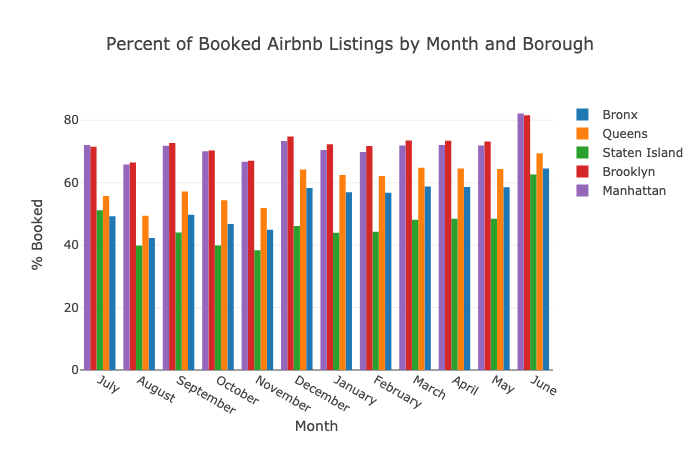

In [25]:
# Plot monthly mean booked by borough
mean_month_booked_bor = availability.groupby(['month', 'neighbourhood_group'], sort=False)['booked'].mean().reset_index()

data = [dict(
  type = 'bar',
  x = mean_month_booked_bor['month'],
  y = mean_month_booked_bor['booked']*100,
  transforms = [dict(
    type = 'groupby',
    groups = mean_month_booked_bor['neighbourhood_group']
  )]
)]

layout = dict(
    yaxis = dict(title = '% Booked'),
    xaxis = dict(title = 'Month', autorange = 'reversed'),
    title = 'Percent of Booked Airbnb Listings by Month and Borough'
)

fig = dict(data=data, layout=layout)
pio.show(fig, validate=False, renderer="iframe_connected+png")

It is no surprise that Manhattan and Brooklyn are the most booked compared to the other boroughs as they tend to be more popular with tourism.  When looking across the two year timeline, Manhattan (green trend line) had the most bookings from June 2018 to June 2019 (2018 dataset), but then interestingly switches places with Brooklyn (orange trend line) starting from June 2019 and consistently remains that way for the next 12 months.  This would indicate that renters are seeking out Brooklyn over Manhattan when booking, it would be interesting to see what the contributing factors of this observation are (for instance rates are generally cheaper in Brooklyn compared to Manhattan).

Let's take a look at some pricing trends.

### Pricing analysis.

Recall, we will use the 2019 `calendar` dataset given that over 70% of the 2018 dataset contained missing prices. Since we are just exploring overall price trends for a typical calendar year, I'm comfortable leaving the 2018 `calendar` dataset out of this analysis since it wouldn't adversely affect our results in this particular case (since we just want to have a general idea for a typical calendar year).

**- QUESTION: How do listing prices vary by location?**

Let's take a look at the overall distribution of **price** per borough.

Highest price in dataset: $20000.0
Lowest price in dataset: $10.0


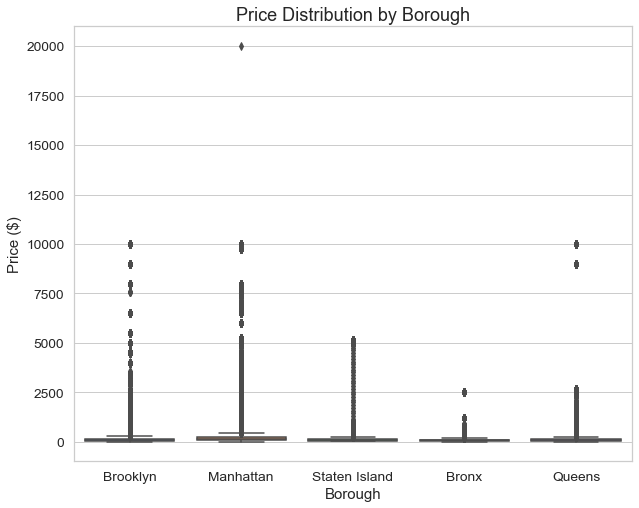

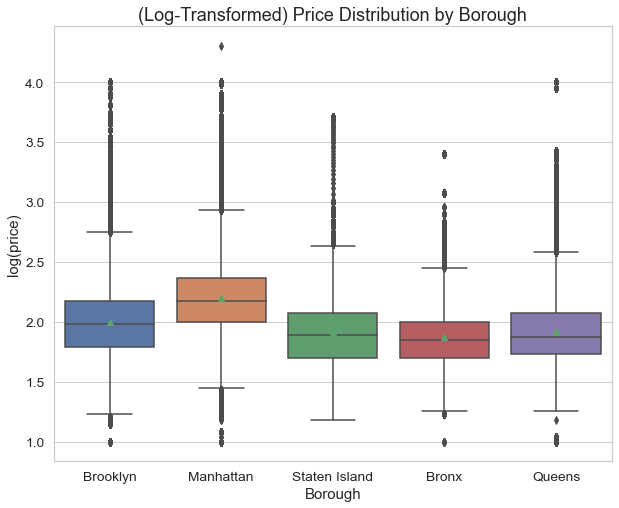

In [26]:
# Use the 2019 dataset since it is complete (there are no NaN's for the price feature)
pricing = cal_final2019.copy()

# Plot distribution of price using boxplot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", font_scale=1.25)
ax = sns.boxplot(x = pricing['neighbourhood_group'], 
                 y = pricing['price'], 
                 data = pricing)

plt.title('Price Distribution by Borough', fontsize=18)
plt.xlabel('Borough')
plt.ylabel('Price ($)')

print('Highest price in dataset: ${}'.format(pricing['price'].max()))
print('Lowest price in dataset: ${}'.format(pricing['price'].min()))

# Plot distribution of log_price using boxplot
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", font_scale=1.25)
ax = sns.boxplot(x = pricing['neighbourhood_group'], 
                 y = np.log10(pricing['price']), 
                 data = pricing,
                 showmeans = True)

plt.title('(Log-Transformed) Price Distribution by Borough', fontsize=18)
plt.xlabel('Borough')
plt.ylabel('log(price)');

In [27]:
display(pricing[pricing['price'] == 20000].head())
display(pricing[pricing['price'] == 10000].drop_duplicates(subset=['listing_id'], keep='first'))

,listing_id,date,available,price,day_of_week,month,year,neighbourhood,neighbourhood_group
16746659,34013027,2019-06-03,0,20000.0,Monday,June,2019,Chinatown,Manhattan


,listing_id,date,available,price,day_of_week,month,year,neighbourhood,neighbourhood_group
3391684,7003697,2019-06-03,0,10000.0,Monday,June,2019,Astoria,Queens
6582652,13894339,2019-06-02,0,10000.0,Sunday,June,2019,Greenpoint,Brooklyn
9648187,20654227,2019-06-07,0,10000.0,Friday,June,2019,Cypress Hills,Brooklyn
10948990,22436899,2019-06-03,0,10000.0,Monday,June,2019,Upper West Side,Manhattan


We see *so* many outliers (hello skewness!) in the first boxplot above such that it's "crushed" to the point where we can't gain any insight into the actual feature.  After applying a log transform to accomodate for the skewness, we are in a much better place and can at least begin to make some observations such as:
* Manhattan has the highest median price out of the five boroughs, followed by Brooklyn.
* Mahattan also has the greatest variability for prices as well as the largest outliers, as opposed to the Bronx borough which has the smallest distribution in price.

After looking up some of these "outlier" listings on Airbnb to confirm their current listed prices, I already see an obvious discrepancy with the most expensive one: the &dollar;20,000 [listing](https://www.airbnb.com/rooms/34013027?source_impression_id=p3_1561861410_N0sl7onEpEYy3OZx) in Chinatown. It's clearly a data entry error since the price is now listed at a much more reasonable rate (< \$300). We can replace this outlier with the median price of that listing to tidy it up a bit.

When checking the \$10,000 priced listings on AirBnb, the prices are consistent with what's currently posted but they appear to be listings that haven't been updated in awhile (e.g. availability hasn't been updated in two years, 0% response rate, etc.) and are also suspiciously priced too high for what the listing space actually is, for instance:
* a private *room* in an apartment in Queens like [this](https://www.airbnb.com/rooms/7003697?source_impression_id=p3_1562307996_XvW8lGy2uj%2FLXSnO)
* a one bedroom apartment in Brooklyn like [this](https://www.airbnb.com/rooms/13894339?source_impression_id=p3_1562308407_6bH93X1waQkePsfa)

This could possibly be due to whether the host has Smart Pricing (a setting that lets a host set their prices to automatically go up or down based on changes in demand for listings like theirs) turned on or how they have it set up, but that is outside of the scope of this analysis. As a possible solution, we can use `quantile()` to compute the 99th quantile of **price**, and remove these outliers.

In [28]:
# Replace $20,000 listing (one row) with the median price of that listing id
median_price_20k = pricing[pricing['listing_id'] == 34013027]['price'].median()
pricing['price'] = np.where(pricing['price'] == 20000, median_price_20k, pricing['price'])
display(pricing[(pricing['date'] == '2019-06-03') & (pricing['listing_id'] == 34013027)].head()) 

# Include only the top 99% of values for 'price' to remove outliers
pricing_no_outliers = pricing[pricing['price'] < pricing['price'].quantile(0.99)]

,listing_id,date,available,price,day_of_week,month,year,neighbourhood,neighbourhood_group
16746659,34013027,2019-06-03,0,377.0,Monday,June,2019,Chinatown,Manhattan


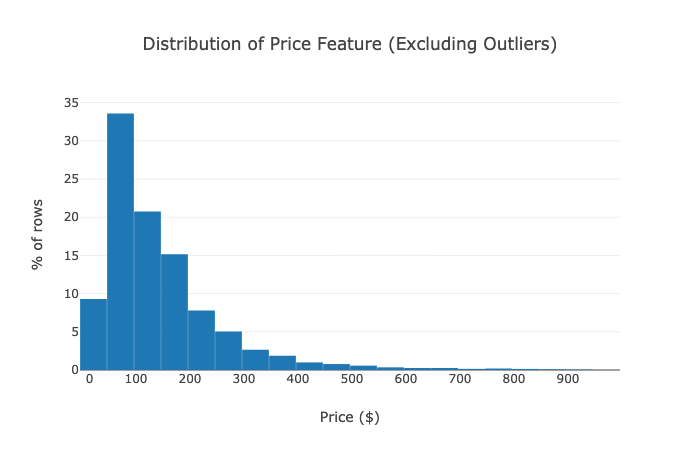

In [29]:
# Transform 'price' by binning
bins = np.arange(0, 1001, step=50)
pricing_no_outliers['bin'] = pd.cut(pricing_no_outliers['price'], bins=bins, right=False, labels=bins[:-1])

# Get freq per bin
perc_bin = pd.DataFrame(pricing_no_outliers['bin'].value_counts(normalize=True, sort=False)*100).reset_index()
perc_bin.columns = ['bin', 'perc']

# Plot binned feature distribution of 'price' with outliers removed
# note: to reduce the size of below fig from MB to KB (huge Series), replaced go.Histogram() with explicit binning and go.Bar()
# data = [go.Histogram(x = pricing_no_outliers['price'], histnorm = 'percent', nbinsx = 21)]
data = [go.Bar(x = perc_bin['bin'].astype(str), 
               y = perc_bin['perc'],
               name = '',
               text = perc_bin['bin'].apply(lambda x: "${0:.0f}".format(x)+" - ${0:.0f}".format(x+49)),
               hovertemplate='Freq: %{y}% <br>' + 'Price: %{text}')]

layout = go.Layout(
    yaxis = dict(title = '% of rows'),
    xaxis = dict(title = 'Price ($)', ticklabelposition='outside left', nticks = perc_bin.index.size),
    title = 'Distribution of Price Feature (Excluding Outliers)',
    bargap = 0.01)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe_connected+png")

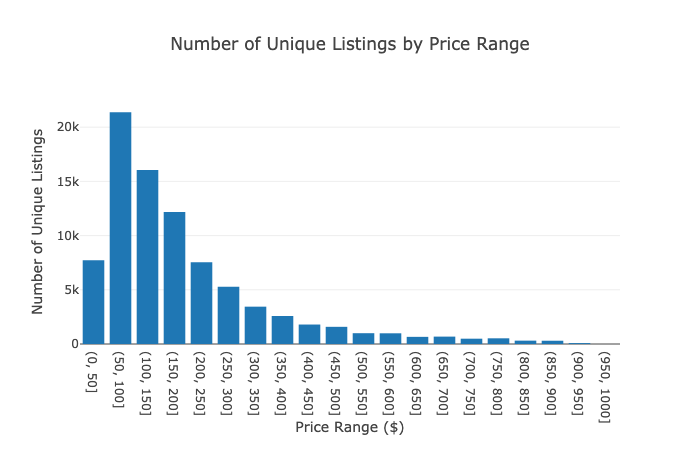

In [30]:
# Transform 'price' by binning
bins = np.arange(0, 1001, step=50)
pricing_no_outliers['bin'] = pd.cut(pricing_no_outliers['price'], bins=bins)

# Group bins by number of unique listings
grp_bin = pricing_no_outliers.groupby('bin', as_index=False).agg(
    {"listing_id": lambda x: x.nunique()})
grp_bin.columns = ['bin', 'nunique']
grp_bin['nunique'].fillna(0, inplace=True)
grp_bin['bin'] = grp_bin['bin'].astype(str)

# Plot number of unique listings for each price range
data = [go.Bar(x=grp_bin['bin'], y=grp_bin['nunique'])]

layout = go.Layout(
    yaxis = dict(title='Number of Unique Listings'),
    xaxis = dict(title='Price Range ($)', automargin=True),
    title = 'Number of Unique Listings by Price Range')

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe_connected+png")

The plots above tell us that the majority of NYC listings range between \$50 and \$200 per night, most of which fall into the \$50 to \$100 price range.

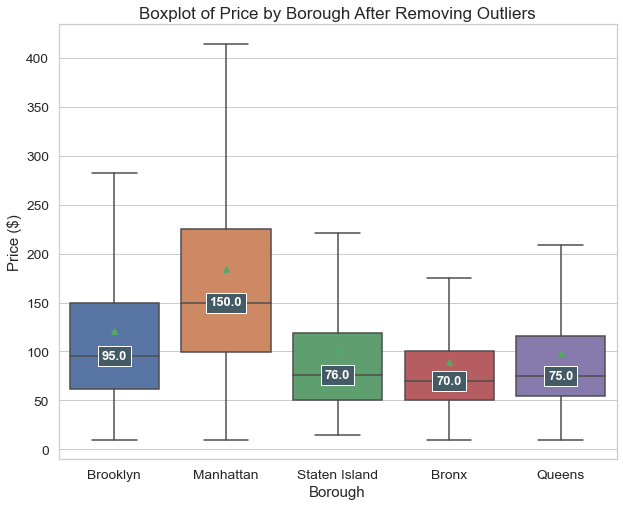

In [31]:
# Plot distribution of price by borough
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", font_scale=1.25)
price_bor = sns.boxplot(x = pricing_no_outliers['neighbourhood_group'], 
                        y = pricing_no_outliers['price'], 
                        data = pricing_no_outliers,
                        showfliers = False,
                        showmeans = True)

# Add labels for median values
ax = price_bor.axes
lines = ax.get_lines()
boroughs = ax.get_xticks()

for bor in boroughs:
    # every 4th line at the interval of 6 is median line
    y = round(lines[4+bor*6].get_ydata()[0],1) 

    ax.text(
        bor, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=13,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
plt.title('Boxplot of Price by Borough After Removing Outliers', fontsize=17)
plt.xlabel('Borough')
plt.ylabel('Price ($)');

After the outliers are removed, we have even a clearer picture of this feature's distribution by borough, seeing how Manhattan is much more widely distributed in price compared to the other boroughs, with a median price of around \$150/night and max value of over \$400. The other boroughs, on the other hand, all have a median price of less then \$100/night, ranging from \$70/night (Bronx, the least distributed) to \$95/night (Brooklyn).

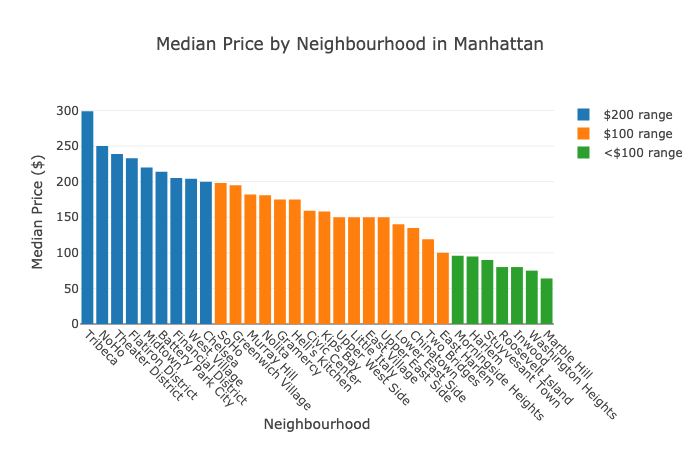

In [32]:
# Median prices by neighbourhood of Manhattan
med_pricing_manhatt = pricing_no_outliers[pricing_no_outliers['neighbourhood_group'] == 'Manhattan'].groupby('neighbourhood')['price'].median().sort_values(ascending=False).reset_index()
med_pricing_manhatt.columns = ['neighbourhood', 'median']
# Create bins for median price ranges
med_pricing_manhatt['label'] = pd.cut(med_pricing_manhatt['median'], [0, 99, 199, 300], labels=['<$100 range', '$100 range', '$200 range'])


# Plot
data = [dict(
    type = 'bar',
    x = med_pricing_manhatt['neighbourhood'],
    y = med_pricing_manhatt['median'],
    transforms = [dict(
        type = 'groupby',
        groups = med_pricing_manhatt['label'])]
)]

layout = dict(
    yaxis = dict(title = 'Median Price ($)'),
    xaxis = dict(title = 'Neighbourhood', automargin = True, tickangle = 45),
    title = 'Median Price by Neighbourhood in Manhattan'
)

# iplot({'data': data, 'layout': layout}, validate=False) 
fig = dict(data=data, layout=layout)
pio.show(fig, validate=False, renderer="iframe_connected+png")

This plot shows that when comparing median price for various neighbourhoods in Manhattan, it is clear that location matters.
* In general, the neighbourhoods starting on the left side of the plot are predominatly in Downtown and Midtown Manhattan.  And as you move towards the right, you'll notice that more neighbourhoods in Uptown Manhattan have the cheaper median prices compared to the rest.
* Tribeca (in Downtown) has the highest (and only) median price around \$300/night, while many other neighbourhoods spanning Downtown (Flatiron, NoHo, Battery Park City, Financial District, West Village) and Midtown (Theater District, Midtown, Chelsea) areas typically have median prices in the \$200 range. 
* In contrast, Uptown neighbourhoods (Harlem, Inwood, Washington Heights, Marble Hill) are considerably cheaper compared to the more expensive areas, with median prices falling under &dollar;100/night.

Note: it's more practical to look at median rather than mean in this case given that median is more robust when it comes to outliers. It is common to have outliers in this data, since prices can substantially fluctuate depending on the season, holiday, etc. (by a few thousand dollars when we are talking about entire floor lofts for instance), and for this reason, removing outliers would negatively affect our results.

**- QUESTION: How do listing prices change throughout the year?**

Instead of just looking at the mean prices over time for the data that has the outliers already removed, it may be insightful to also plot the mean prices with outliers included since it's normal for prices to spike substantially (e.g. a few thousand dollars) on holidays (particularly New Years Eve on December 31st) for larger venues where someone might want to rent out an entire art gallary/loft like [this](https://www.airbnb.com/rooms/4777903?source_impression_id=p3_1562444143_3TIesborJ7duF%2BX3) to bring in the New Year in style.

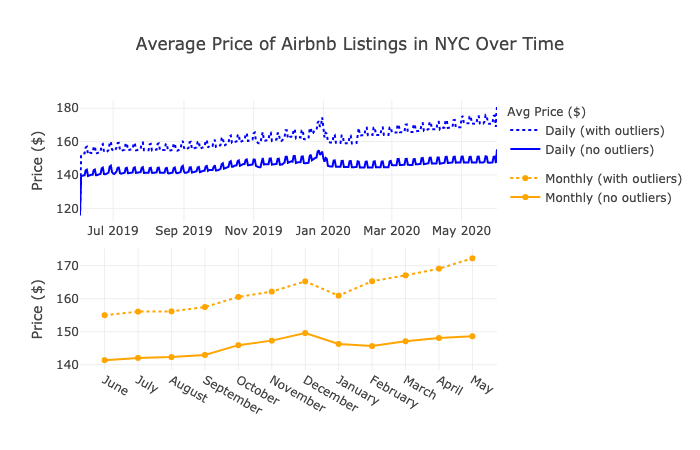

In [33]:
# Group mean of prices by date and month
mean_date_pricing = pricing_no_outliers.groupby('date')['price'].mean().reset_index()
mean_month_pricing = pricing_no_outliers.groupby('month', sort = False)['price'].mean().reset_index()
mean_date_pricing_all = pricing.groupby('date')['price'].mean().reset_index()
mean_month_pricing_all = pricing.groupby('month', sort = False)['price'].mean().reset_index()

# Plot
trace0 = go.Scatter(
    x = mean_date_pricing_all['date'], 
    y = mean_date_pricing_all['price'],
    name = 'Daily (with outliers)',
    legendgroup = 'day',
    xaxis = 'x2',
    yaxis = 'y2',
    line=dict(color='blue', dash='dot')
)
trace1 = go.Scatter(
    x = mean_date_pricing['date'], 
    y = mean_date_pricing['price'],
    name = 'Daily (no outliers)',
    legendgroup = 'day',
    xaxis = 'x2',
    yaxis = 'y2',
    line = dict(color='blue')
)
trace2 = go.Scatter(
    x = mean_month_pricing_all['month'], 
    y = mean_month_pricing_all['price'],
    name = 'Monthly (with outliers)',
    legendgroup = 'month',
    line=dict(color='orange', dash='dot')
)
trace3 = go.Scatter(
    x = mean_month_pricing['month'], 
    y = mean_month_pricing['price'],
    name = 'Monthly (no outliers)',
    legendgroup = 'month',
    line=dict(color='orange')
)
# data = [trace3, trace2, trace1, trace0]
data = [trace0, trace1, trace2, trace3]
layout = go.Layout(
    title = 'Average Price of Airbnb Listings in NYC Over Time',
    yaxis = dict(title = 'Price ($)', domain = [0, 0.45]),
    xaxis2 = dict(anchor = 'y2'),
    yaxis2 = dict(title = 'Price ($)', domain = [0.55, 1], anchor = 'x2'),
    legend = dict(traceorder = 'grouped', title_text='Avg Price ($)'),
    height = 700
)

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe_connected+png")

The temporal plots above suggest that there may be somewhat of a linear upward trend, as well as a clear indication of seasonality (reflected in first plot) where the amplitude of the cycles appears to be mostly consistent.  So in general, it appears that the average nightly price is slowly increasing over time, with the exception of the following:
* late December where there is a noticibly larger price increase around the time of New Years Eve (December 31st)
* entire month of January where there is a noticable price drop most likely due to the fact that it's the coldest (wintry) month in NYC

I'd like to note the spike on December 31st - particularly on the trend line that includes the outliers - where listings like [this](https://www.airbnb.com/rooms/4777903?source_impression_id=p3_1562444143_3TIesborJ7duF%2BX3) would not have been otherwise captured if we only looked at our pricing data with the outliers excluded.  This listing is just one example where it is labeled as an outlier using `quantile()` but is still a legitimate data point.

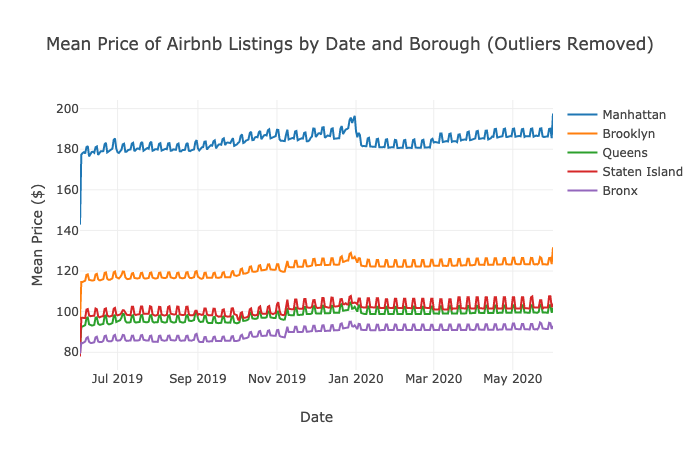

In [34]:
# Group mean price by date and borough
date_bor_all = pricing.groupby(['date', 'neighbourhood_group'])['price'].mean().reset_index()
date_bor_no_outl = pricing_no_outliers.groupby(['date', 'neighbourhood_group'])['price'].mean().reset_index()

dict_of_fig = dict({
        'data': [
            {
                'x': date_bor_no_outl[date_bor_no_outl['neighbourhood_group']==neighbourhood_group]['date'],
                'y': date_bor_no_outl[date_bor_no_outl['neighbourhood_group']==neighbourhood_group]['price'],
                'name': neighbourhood_group, 'mode': 'lines',
            } for neighbourhood_group in ['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx']
        ],
        'layout': {
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': "Mean Price ($)"},
            'title': 'Mean Price of Airbnb Listings by Date and Borough (Outliers Removed)'
        }
})

fig = go.Figure(dict_of_fig)
fig.show(renderer="iframe_connected+png")

Looking at the temporal price trend per borough:
* Manhattan consistently has the highest mean price and continues to set itself apart from the other boroughs in the trend.
* We see the price spike around December 31st reflected across all 5 boroughs, Manhattan showing the most obvious increase while the others showing it just subtly which would indicate that listings in Manhattan are likely to increase more in price during that time compared to listings in the other boroughs.


## 4. Evaluating the Results

To recap, here are the results from our analysis.
-  **Which NYC areas have the most listings?**
    * Manhattan and Brooklyn by far have the most number of listings when comparing the boroughs, comprising of 85% of all listings in the 2019 calendar dataset. Manhattan alone has a total of over 30k unique listings between the 2018 and 2019 datasets, which is not surprising since it is the most popular borough from a tourism perspective.
    * Harlem (in Uptown Manhattan) has the most number of listings compared to other neighbourhoods, consisting of over 600 more listings than the next neighbourhood with the second highest count, Upper West Side (also Uptown). 
    * When considering what general areas of Manhattan - Uptown, Midtown, and Downtown - these neighbourhoods are in, the neighbourhoods that have:
        * \> 1000 listings are predominantly in Uptown and Midtown 
        * 500-1000 listings are predominantly Downtown
        * 100-500 listings are predominantly Midtown and Downtown
        * < 100 listings are predominantly Downtown
-  **What does availability for listings look like throughout the year?**
    * When grouping by date, we can see a similar pattern (i.e. seasonality) of average listings booked across the two year time range (June 2018 to June 2020), where the most booked listings are throughout the month of June followed by late December going into the new year.
        * This makes sense for late December since many people venture in to celebrate Christmas time (and see the famous Rockefeller Center Christmas Tree), as well as to bring in the new year in style for New Years Eve (December 31st).
        * As for June, the reason it shows the highest percentage of bookings is due to the fact that it is the **starting month** of the data collection/extraction process for the next June calendar year, thus the listings for this month reflect the most recent (and thus the most number of) bookings.
    * On the other hand, we can see the least booked listings occur during late August and late November. This may be reflective of NYC's most hot and humid month (August) and Thanksgiving (end of November) where people tend to spend time at home with family rather than travel for vacation.
    * It is no surprise that Manhattan and Brooklyn are the most booked compared to the other boroughs as they tend to be more popular with tourism. When looking across the two year timeline, Manhattan had the most bookings from June 2018 to June 2019 (2018 dataset), but then interestingly switches places with Brooklyn starting from June 2019 and consistently remains that way for the next 12 months. This would indicate that renters are seeking out Brooklyn over Manhattan when booking.
-  **How do listing prices vary by location?**
    * Manhattan is much more widely distributed in price compared to the other boroughs, with a median price of around \$150/night and max value of over \$400. The other boroughs, on the other hand, all have a median price of less then \$100/night, ranging from \$70/night (Bronx, the least distributed) to \$95/night (Brooklyn).
    * When comparing median price for various neighbourhoods in Manhattan, it is clear that location matters.  In general, the neighbourhoods with the highest median prices are predominatly in Downtown and Midtown Manhattan, while more neighbourhoods in Uptown Manhattan have the cheaper median prices.
        * Tribeca (in Downtown) has the highest (and only) median price around \$300/night, while many other neighbourhoods spanning Downtown (Flatiron, NoHo, Battery Park City, Financial District, West Village) and Midtown (Theater District, Midtown, Chelsea) areas typically have median prices in the \$200 range.
        * In contrast, Uptown neighbourhoods (Harlem, Inwood, Washington Heights, Marble Hill) are considerably cheaper compared to the more expensive areas, with median prices falling under \$100/night.
-  **How do listing prices change throughout the year?**
    * It appears that the average nightly price is slowly increasing over time (as well as a clear indication of seasonality), with the exception of the following:
        * late December where there is a noticibly larger price increase around the time of New Years Eve (December 31st)
        * entire month of January where there is a noticable price drop most likely due to the fact that it's the coldest (wintry) month in NYC.
    * Looking at the temporal price trend per borough, Manhattan consistently has the highest mean price and continues to set itself apart from the other boroughs in the trend.
    * We see the price spike around December 31st reflected across all 5 boroughs, Manhattan showing the most obvious increase while the others showing it just subtly which would indicate that listings in Manhattan are likely to increase more in price during that time compared to listings in the other boroughs.